## Pre-Processing and Visualization

In [0]:
import random
import warnings
import pandas
import numpy
import json
from numpy import newaxis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU
import tensorflow.keras.backend as K

plt.style.use('ggplot')

In [6]:
print(plt.rcParams.keys())
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['figure.titlesize'] = 12

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#E5E5E5',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [7]:
!wget https://pomber.github.io/covid19/timeseries.json

--2020-04-08 20:08:45--  https://pomber.github.io/covid19/timeseries.json
Resolving pomber.github.io (pomber.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to pomber.github.io (pomber.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1457480 (1.4M) [application/json]
Saving to: ‘timeseries.json’

timeseries.json     100%[===================>]   1.39M  --.-KB/s    in 0.1s    

2020-04-08 20:08:45 (11.7 MB/s) - ‘timeseries.json’ saved [1457480/1457480]



In [0]:
with open('timeseries.json') as f:
    full_data = json.load(f)

In [0]:
def process_country_data(full_data, country):
    country_data = full_data[country]
    date = []
    confirmed = []
    deaths = []
    recovered = []

    for element in country_data:
        date.append(str(element['date']))
        confirmed.append(float(element['confirmed']))
        deaths.append(float(element['deaths']))
        recovered.append(float(element['recovered']))

    timeseries_dictionary = {'Date': date, 'Confirmed': confirmed, 'Dead': deaths, 'Recovered': recovered}
    country_timeseries = pandas.DataFrame(timeseries_dictionary)
    return country_timeseries

In [0]:
'''
!!! 
    Please change the country name in the below function to `India` or `China`
    for doing analysis for those countries.
!!!
'''
country_data = process_country_data(full_data, 'US')
evaluation_index = country_data.shape[0] - 10

In [0]:
# Function for generating the walk-forward validation set.
def walk_forward_validation(unsplit_data, base_window_size, column):
    X = []
    Y = []

    while base_window_size < unsplit_data.shape[0]:
        validation_sequence = unsplit_data.iloc[: base_window_size, unsplit_data.columns.get_loc(column)].tolist()
        validation_test = unsplit_data.iloc[base_window_size, unsplit_data.columns.get_loc(column)]
        X.append(validation_sequence)
        Y.append(validation_test)
        base_window_size += 1

    return X, Y

## Line Plots

Text(0, 0.5, 'Number of Cases')

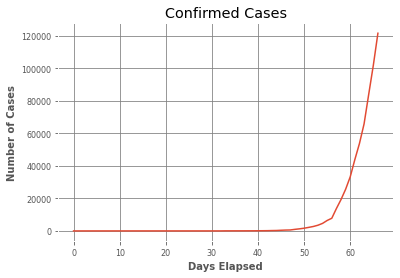

In [12]:
# Plot the line plot for training set on confirmed cases.
country_data.iloc[: evaluation_index, country_data.columns.get_loc('Confirmed')].plot.line(x = 'Date', y = 'Confirmed', title = 'Confirmed Cases')
plt.xlabel('Days Elapsed')
plt.ylabel('Number of Cases')

Text(0, 0.5, 'Number of Cases')

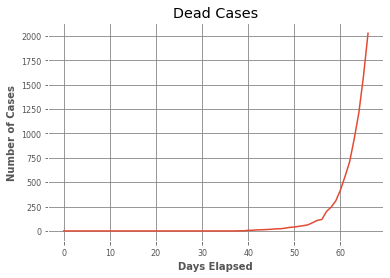

In [13]:
# Plot the line plot for training set on dead cases.
country_data.iloc[: evaluation_index, country_data.columns.get_loc('Dead')].plot.line(x = 'Date', y = 'Dead', title = 'Dead Cases')
plt.xlabel('Days Elapsed')
plt.ylabel('Number of Cases')

Text(0, 0.5, 'Number of Cases')

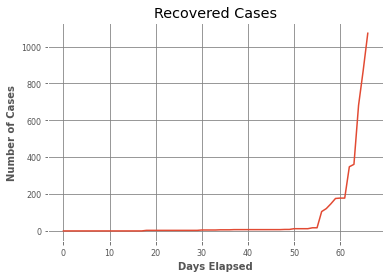

In [14]:
# Plot the line plot for training set on recovered cases.
country_data.iloc[: evaluation_index, country_data.columns.get_loc('Recovered')].plot.line(x = 'Date', y = 'Recovered', title = 'Recovered Cases')
plt.xlabel('Days Elapsed')
plt.ylabel('Number of Cases')

## Naive Forecast / Persistence

In [0]:
# Function for generating naive forecasts.
def naive_forecast(X):
    forecast = []
    
    for x in X:
        forecast.append(x[-1])
    
    return forecast

In [0]:
def run_naive_forecast(metric):
    X, Y = walk_forward_validation(country_data, 3, metric)
    XTrain = X[: evaluation_index - 3]
    YTrain = Y[: evaluation_index - 3]
    XTest = X[evaluation_index - 3 :]
    YTest = Y[evaluation_index - 3 :]
    # Print the RMSE for Naive Forecasting.
    print('Naive Forecast Evaluation: ', metric, 'Cases')
    YTrainPred = naive_forecast(XTrain)
    print('Training RMSE: ', mean_squared_error(YTrain, YTrainPred, squared = False))
    YTestPred = naive_forecast(XTest)
    print('Testing RMSE: ', mean_squared_error(YTest, YTestPred, squared = False))
    # Plot the results.
    x = country_data.iloc[evaluation_index :, 0].values
    plt.plot(x, YTest, label = 'Test Values')
    plt.plot(x, YTestPred, color = 'purple', label = 'Predicted Values')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title('Naive Forecast Predictions: ' + metric + ' Cases')
    plt.xticks(rotation = 90)
    plt.show()

Naive Forecast Evaluation:  Confirmed Cases
Training RMSE:  4943.5570000253865
Testing RMSE:  27808.80031033342


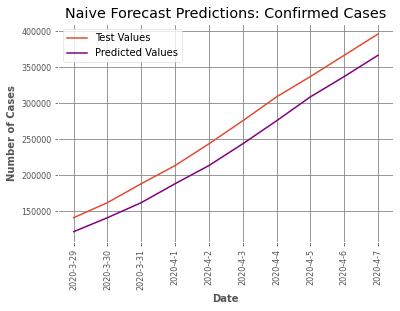

Naive Forecast Evaluation:  Dead Cases
Training RMSE:  91.12199926472202
Testing RMSE:  1143.6138334245525


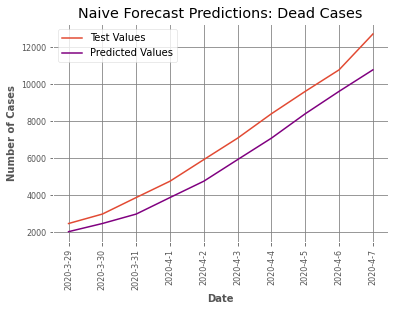

Naive Forecast Evaluation:  Recovered Cases
Training RMSE:  58.309518948453004
Testing RMSE:  2403.6765381390233


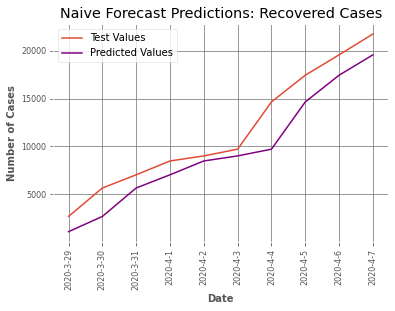

In [17]:
# Generate the walk-forward training and testing sets.
run_naive_forecast('Confirmed')
run_naive_forecast('Dead')
run_naive_forecast('Recovered')

## ARIMA Modelling

In [0]:
# Function for evaluating the dataset on an ARIMA configuration.
def evaluate_arima_model(train, test, arima_order):
    history = [x[0] for x in train]
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        try:
            model_fit = model.fit(trend = 'nc', disp = 0, transparams = False)
        except:
            model_fit = model.fit(trend = 'nc', disp = 0, start_params = [.1, .1, .1])
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    mse = mean_squared_error(test, predictions, squared = False)
    return mse, predictions

In [0]:
# Function for grid-searching the best ARIMA configuration.
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg, best_predictions = float("inf"), None, None
    train, test = dataset[0 : evaluation_index], dataset[evaluation_index : ]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse, predictions = evaluate_arima_model(train, test, order)

                    if mse < best_score:
                        best_score, best_cfg, best_predictions = mse, order, predictions
                except:
                    continue
                print('ARIMA Configuration: %s RMSE = %.3f' % (order, mse))
    
    print('\nBest ARIMA Configuration: %s RMSE = %.3f' % (best_cfg, best_score))
    return (test, best_predictions)

In [0]:
country_data.loc[:, ['Date', 'Confirmed']].to_csv('Confirmed.csv', index = False)
country_data.loc[:, ['Date', 'Dead']].to_csv('Dead.csv', index = False)
country_data.loc[:, ['Date', 'Recovered']].to_csv('Recovered.csv', index = False)

Initiating Grid Search
ARIMA Configuration: (1, 1, 2) RMSE = 3196.518
ARIMA Configuration: (1, 2, 2) RMSE = 3315.744
ARIMA Configuration: (2, 1, 1) RMSE = 3090.503
ARIMA Configuration: (2, 2, 1) RMSE = 2992.485

Best ARIMA Configuration: (2, 2, 1) RMSE = 2992.485


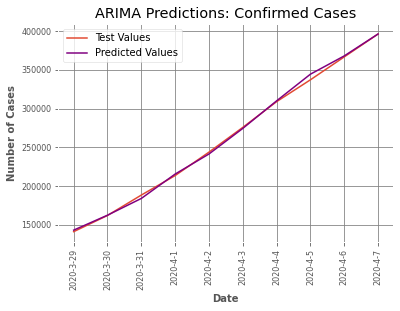

In [63]:
# Routine for generating the best ARIMA model plots for confirmed cases.
x = country_data.iloc[evaluation_index :, 0].values
series = pandas.read_csv('Confirmed.csv', index_col = 'Date', parse_dates = True)
p_values = range(1, 8)
d_values = range(1, 8)
q_values = range(1, 8)
warnings.filterwarnings("ignore")

print('Initiating Grid Search')
test, predictions = evaluate_models(series.values, p_values, d_values, q_values)
plt.plot(x, test, label = 'Test Values')
plt.plot(x, predictions, color = 'purple', label = 'Predicted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('ARIMA Predictions: Confirmed Cases')
plt.xticks(rotation = 90)
plt.show()

Initiating Grid Search
ARIMA Configuration: (1, 1, 2) RMSE = 15.109
ARIMA Configuration: (1, 2, 1) RMSE = 12.802
ARIMA Configuration: (1, 2, 2) RMSE = 14.397
ARIMA Configuration: (2, 1, 1) RMSE = 13.848
ARIMA Configuration: (2, 2, 1) RMSE = 13.599

Best ARIMA Configuration: (1, 2, 1) RMSE = 12.802


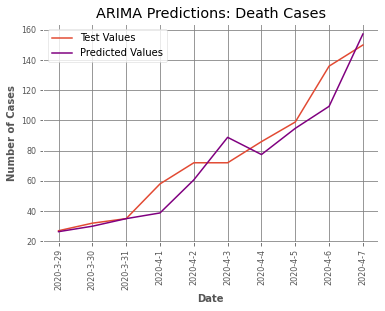

In [18]:
# Routine for generating the best ARIMA model plots for dead cases.
x = country_data.iloc[evaluation_index :, 0].values
series = pandas.read_csv('Dead.csv', index_col = 'Date', parse_dates = True)
p_values = range(1, 8)
d_values = range(1, 8)
q_values = range(1, 8)
warnings.filterwarnings("ignore")

print('Initiating Grid Search')
test, predictions = evaluate_models(series.values, p_values, d_values, q_values)
plt.plot(x, test, label = 'Test Values')
plt.plot(x, predictions, color = 'purple', label = 'Predicted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('ARIMA Predictions: Death Cases')
plt.xticks(rotation = 90)
plt.show()

Initiating Grid Search
ARIMA Configuration: (1, 1, 2) RMSE = 40.598
ARIMA Configuration: (1, 2, 2) RMSE = 59.614
ARIMA Configuration: (2, 1, 1) RMSE = 50.841
ARIMA Configuration: (2, 2, 1) RMSE = 48.289

Best ARIMA Configuration: (1, 1, 2) RMSE = 40.598


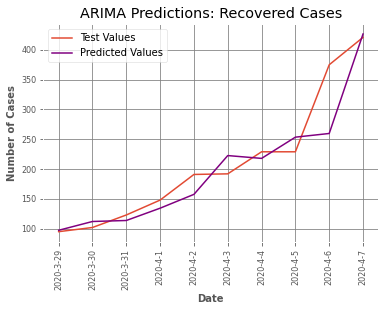

In [19]:
# Routine for generating the best ARIMA model plots for recovered cases.
x = country_data.iloc[evaluation_index :, 0].values
series = pandas.read_csv('Recovered.csv', index_col = 'Date', parse_dates = True)
p_values = range(1, 8)
d_values = range(1, 8)
q_values = range(1, 8)
warnings.filterwarnings("ignore")

print('Initiating Grid Search')
test, predictions = evaluate_models(series.values, p_values, d_values, q_values)
plt.plot(x, test, label = 'Test Values')
plt.plot(x, predictions, color = 'purple', label = 'Predicted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('ARIMA Predictions: Recovered Cases')
plt.xticks(rotation = 90)
plt.show()

## GRU Modelling

In [0]:
# Function for preparing datasets to be fed into a GRU.
def load_data(datasetname, column, sequence_length, normalise_window):
    data = datasetname.loc[:, column]
    result = []

    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])

    result = numpy.array(result)
    train = result[: -10, :]
    x_train = train[:, : -1]
    y_train = train[:, -1]
    x_test = result[-10 :, : -1]
    y_test = result[-10 :, -1]
    x_train = numpy.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = numpy.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

# Function for predicting the next sequence.
def predict_sequence_full(model, data):
    predicted = []

    for i in range(len(data)):
        curr_frame = data[i]
        predicted.append(model.predict(curr_frame[newaxis, :, :])[0, 0])

    return predicted

# Function for plotting the prediction results.
def plot_results(predicted_data, true_data, metric): 
    x = country_data.iloc[-10 :, 0].values
    fig = plt.figure(facecolor = 'white') 
    ax = fig.add_subplot(111) 
    ax.plot(x, true_data, label = 'Test Values') 
    plt.plot(x, predicted_data, color = 'purple', label = 'Predicted Values') 
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title('GRU Predictions: ' + metric + ' Cases')
    plt.xticks(rotation = 90)
    plt.show()
    print(predicted_data)

# Function for emulating the RMSE loss.
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
series = pandas.read_csv('Confirmed.csv', index_col = 'Date', parse_dates = True)
#series['Confirmed'][:-2].plot(figsize = (16, 4),legend = False)
series = series.iloc[:, :]

In [51]:
# Implement model and train on dataset for confirmed cases time series.
feature_train, label_train, feature_test, label_test = load_data(series, 'Confirmed', 5, False)

model = Sequential()
model.add(GRU(100, activation = 'relu', return_sequences = True, input_shape = (feature_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(50, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
adam = optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = root_mean_squared_error, optimizer = adam)

model.fit(feature_train, label_train, batch_size = 1, epochs = 1, validation_data = (feature_test, label_test))

60/60 [==============================] - 1s 9ms/step - loss: 3377.6521 - val_loss: 65108.5430


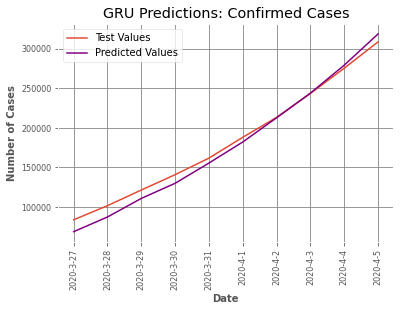

[68806.82, 87381.086, 110866.836, 129981.71, 155609.67, 182223.28, 212844.94, 244060.5, 279396.16, 318845.28]


In [46]:
# Predict the sequence.
predictions = predict_sequence_full(model, feature_test)
plot_results(predictions, label_test, 'Confirmed')

In [0]:
series = pandas.read_csv('Dead.csv', index_col = 'Date', parse_dates = True)
#series['Dead'][:-2].plot(figsize = (16, 4),legend = False)
series = series.iloc[:, :]

In [54]:
# Implement model and train on dataset for dead cases time series.
feature_train, label_train, feature_test, label_test = load_data(series, 'Dead', 5, False)

model = Sequential()
model.add(GRU(100, activation = 'relu',return_sequences = True, input_shape = (feature_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(50, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
adam = optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = root_mean_squared_error, optimizer = adam)

model.fit(feature_train, label_train, batch_size = 1, epochs = 15, validation_data = (feature_test, label_test))

Epoch 1/15
60/60 [==============================] - 1s 9ms/step - loss: 62.2596 - val_loss: 3025.8789
Epoch 2/15
60/60 [==============================] - 0s 4ms/step - loss: 20.0120 - val_loss: 758.8813
Epoch 3/15
60/60 [==============================] - 0s 4ms/step - loss: 9.6743 - val_loss: 372.3429
Epoch 4/15
60/60 [==============================] - 0s 4ms/step - loss: 13.0170 - val_loss: 285.1094
Epoch 5/15
60/60 [==============================] - 0s 4ms/step - loss: 22.6483 - val_loss: 176.4028
Epoch 6/15
60/60 [==============================] - 0s 4ms/step - loss: 11.0241 - val_loss: 605.3130
Epoch 7/15
60/60 [==============================] - 0s 4ms/step - loss: 9.1974 - val_loss: 150.4394
Epoch 8/15
60/60 [==============================] - 0s 4ms/step - loss: 9.1772 - val_loss: 1196.1487
Epoch 9/15
60/60 [==============================] - 0s 4ms/step - loss: 14.7494 - val_loss: 903.7764
Epoch 10/15
60/60 [==============================] - 0s 4ms/step - loss: 14.0397 - val_loss:

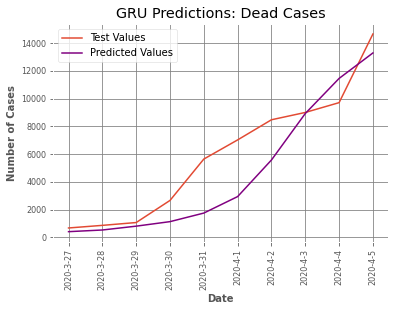

[415.0329, 535.07196, 811.9064, 1137.324, 1754.3706, 2941.9048, 5577.135, 8923.497, 11451.07, 13286.389]


In [59]:
# Predict the sequence.
spredictions = predict_sequence_full(model, feature_test)
plot_results(predictions, label_test, 'Dead')

In [0]:
series = pandas.read_csv('Recovered.csv', index_col = 'Date', parse_dates = True)
#series['Recovered'][:-2].plot(figsize = (16, 4),legend = False)
series = series.iloc[:-2, :]

In [57]:
# Implement model and train on dataset for recovered cases time series.
feature_train, label_train, feature_test, label_test = load_data(series, 'Recovered', 5, False)

model = Sequential()
model.add(GRU(100, activation = 'relu', return_sequences = True, input_shape = (feature_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(50, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
adam = optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = root_mean_squared_error, optimizer = adam)

model.fit(feature_train, label_train, batch_size = 1, epochs = 20, validation_data = (feature_test, label_test))

Epoch 1/20
60/60 [==============================] - 1s 10ms/step - loss: 29.3008 - val_loss: 5687.4697
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 28.7905 - val_loss: 5565.6562
Epoch 3/20
60/60 [==============================] - 0s 5ms/step - loss: 27.9147 - val_loss: 5413.6411
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 26.7049 - val_loss: 5208.4365
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 25.2616 - val_loss: 4721.5938
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 22.8328 - val_loss: 4241.8096
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 15.1159 - val_loss: 2315.3997
Epoch 8/20
60/60 [==============================] - 0s 6ms/step - loss: 6.9345 - val_loss: 2068.4790
Epoch 9/20
60/60 [==============================] - 0s 5ms/step - loss: 6.4075 - val_loss: 2079.5398
Epoch 10/20
60/60 [==============================] - 0s 5ms/step - loss: 11.8439 - 

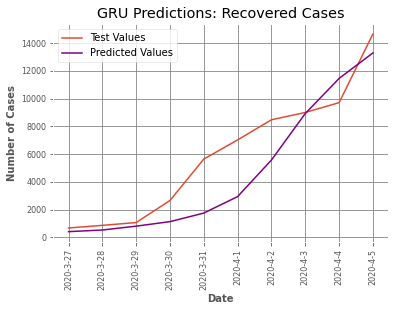

[415.0329, 535.07196, 811.9064, 1137.324, 1754.3706, 2941.9048, 5577.135, 8923.497, 11451.07, 13286.389]


In [58]:
# Predict the sequence.
predictions = predict_sequence_full(model, feature_test)
plot_results(predictions, label_test, 'Recovered')